# Explaining Machine Learning

Interpretability of Machine Learning models has recently become a relevant
 research direction to more thoroughly address and mitigate the issues of
 adversarial examples and to better understand the potential flaws of the
 most recent algorithm such as Deep Neural Networks.

In this tutorial, we explore different methods to compute
 *post-hoc* explanations, which consist of analyzing a trained model to
 understand which components such as features or training prototypes are
 more relevant during the decision (classification) phase.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/maurapintor/unica_mlsec_labs/blob/HEAD/06_explainability.ipynb)

In [28]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

%pip install torch
%pip install torchvision
%pip install captum
%pip install foolbox
%pip install transformers
%pip install datasets
%pip install shap

In [29]:
import torch
from torchvision import models, transforms
import requests
from PIL import Image
import io
import numpy as np
from captum.attr import visualization as viz

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

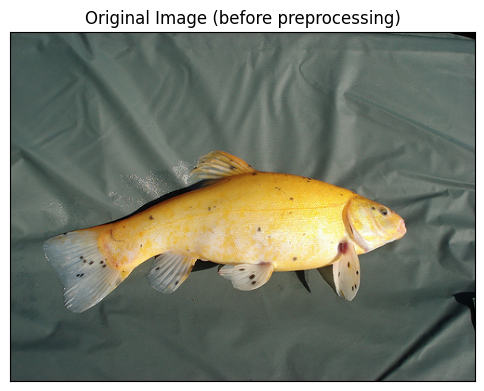

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Original Image (before preprocessing)'}>)

In [31]:
# we load an image from the ImageNet dataset (check the repository for other available images)
img_url = "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01440764_tench.JPEG?raw=true"
y_true = 0  # taken from the repository
r = requests.get(img_url)
img = Image.open(io.BytesIO(r.content))

# we visualize the image with the captum utils
viz.visualize_image_attr(None, np.asarray(img), method="original_image", title="Original Image (before preprocessing)")

In [32]:
def tensor_to_img_array(t):
  """Converts a pytorch tensor representation of an image to a numpy array"""
  return np.transpose(t.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [33]:
# we load the pretrained weights on the ImageNet dataset...
weights = models.ResNet50_Weights.IMAGENET1K_V1

# ...and initialize the model with them
model = models.resnet50(weights=weights).to(device)
model.eval()

# the weights object wraps the input preprocessing steps
preprocess = weights.transforms()  # resize (256), center crop (224), normalize

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 96.3MB/s]


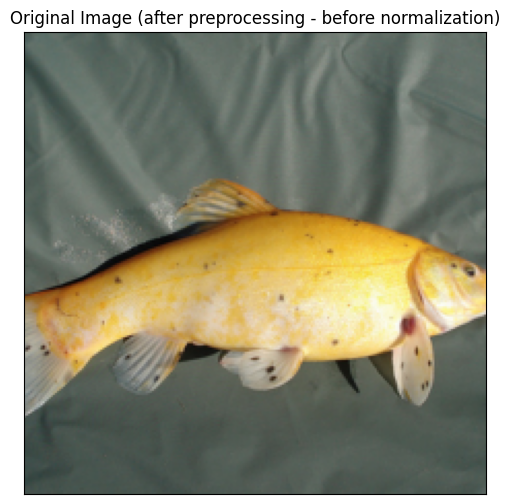

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Original Image (after preprocessing - before normalization)'}>)

In [34]:
# preprocess the image
x = preprocess(img).unsqueeze(0).to(device)

# invert the normalization in order to visualize the input image
unnorm_x = x.cpu().squeeze(0).mul_(torch.as_tensor(preprocess.std).view(-1, 1, 1)).add_(torch.as_tensor(preprocess.mean).view(-1, 1, 1))
input_img = tensor_to_img_array(unnorm_x)

viz.visualize_image_attr(None, input_img, method="original_image", title="Original Image (after preprocessing - before normalization)")

In [35]:
print("y_true:", weights.meta["categories"][y_true])

y_true: tench


In [36]:
def classify(model, x):
  """Classifies the image and return the output label and the logits"""
  output_scores = model(x).squeeze(0)
  y_pred = output_scores.softmax(0).argmax()
  return y_pred, output_scores

In [37]:
y_pred, _ = classify(model, x)
print("y_pred:", weights.meta["categories"][y_pred.item()])

y_pred: tench


In [38]:
def visualize_attributions(attrs, method_name):
  """Plot the attributions scores in three different ways"""
  viz.visualize_image_attr_multiple(
      tensor_to_img_array(attrs), input_img,
      methods=["heat_map", "blended_heat_map", "masked_image"],
      signs=["positive", "positive", "positive"], show_colorbar=True,
      titles=[f"{method_name} (heatmap)", f"{method_name} (overlay)", f"{method_name} (masked img)"])

## Feature-based explanations

Feature-based explanation methods assign a value to each feature of an input sample depending on how relevant it is towards the classification decision. These relevance values are often called *attributions*.

We start with four *gradient-based* white-box explanation methods, applied on the image classification domain.

For all of them, we always have to choose the class label with respect to the explanation should be computed.

### Gradient

 Compute gradients of the output class w.r.t. the input.

 > [[baehrens2010explain]](http://www.jmlr.org/papers/volume11/baehrens10a/baehrens10a.pdf)
 > D. Baehrens, T. Schroeter, S. Harmeling, M. Kawanabe, K. Hansen,
 > K.-R.Muller, "How to explain individual classification decisions",
 > in: J. Mach. Learn. Res. 11 (2010) 1803-1831

In [39]:
x.requires_grad = True
y_pred, scores = classify(model, x)
attr_grad = torch.autograd.grad(scores[y_pred], [x])[0]

model.zero_grad()

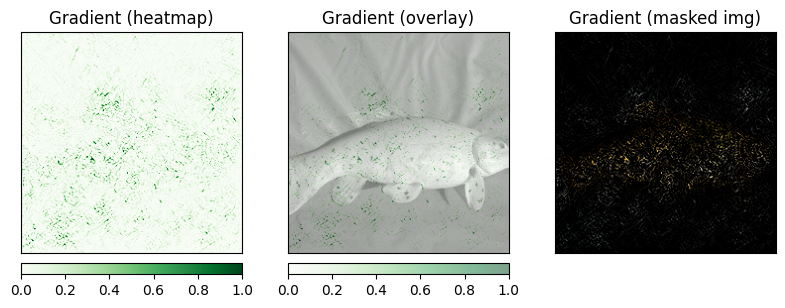

In [40]:
visualize_attributions(attr_grad, "Gradient")

### Gradient * Input

 Decomposes the output on a specific input by backpropagating the contributions of all neurons to every feature, providing a linear approximation.

 > [[shrikumar2016not]](https://arxiv.org/pdf/1605.01713)
 > A. Shrikumar, P. Greenside, A. Shcherbina, A. Kundaje,
 > "Not just a blackbox: Learning important features through propagating
 > activation differences", 2016 arXiv:1605.01713.

 > [[melis2018explaining]](https://arxiv.org/abs/1803.03544)
 > M. Melis, D. Maiorca, B. Biggio, G. Giacinto and F. Roli,
 > "Explaining Black-box Android Malware Detection," 2018 26th European
 > Signal Processing Conference (EUSIPCO), Rome, 2018, pp. 524-528.


In [41]:
attr_input_x_grad = x * attr_grad

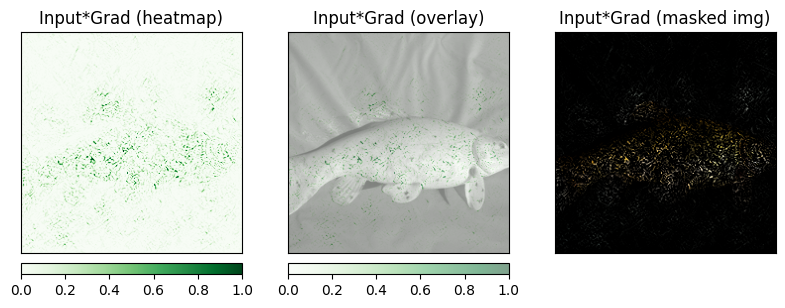

In [42]:
visualize_attributions(attr_input_x_grad, "Input*Grad")

### Integrated Gradients

  Improves the linear approximation by integrating the model’s output along the path between the input and a reference sample.

  > [[sundararajan2017axiomatic]](https://arxiv.org/pdf/1703.01365)
  > Sundararajan, Mukund, Ankur Taly, and Qiqi Yan. "Axiomatic Attribution
  > for Deep Networks." Proceedings of the 34th International Conference on
  > Machine Learning, Volume 70, JMLR. org, 2017, pp. 3319-3328.

In [43]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)
attr_ig = ig.attribute(x, target=y_pred, baselines = x * 0)

model.zero_grad()

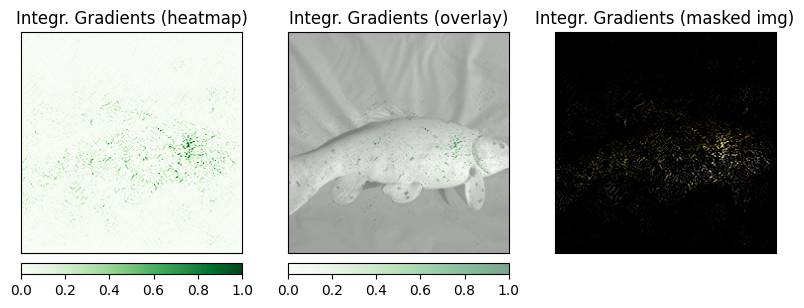

In [44]:
visualize_attributions(attr_ig, "Integr. Gradients")

### SmoothGrad

Computes the attributions multiple times, adding Gaussian noise to the input each time, and averages them.

 > [[smilkov2017smoothgrad]](https://arxiv.org/pdf/1706.03825)
  > Smilkov, Daniel, Nikhil Thorat, Been Kim, Fernanda B. Viégas and Martin Wattenberg.
  > "SmoothGrad: removing noise by adding noise." Workshop on Visualization for Deep Learning, ICML, 2017.

  

In [45]:
from captum.attr import Saliency, NoiseTunnel

saliency = Saliency(model)
sg = NoiseTunnel(saliency)
attr_sg = sg.attribute(x, target=y_pred, nt_type="smoothgrad", nt_samples=100, stdevs=0.1)

model.zero_grad()

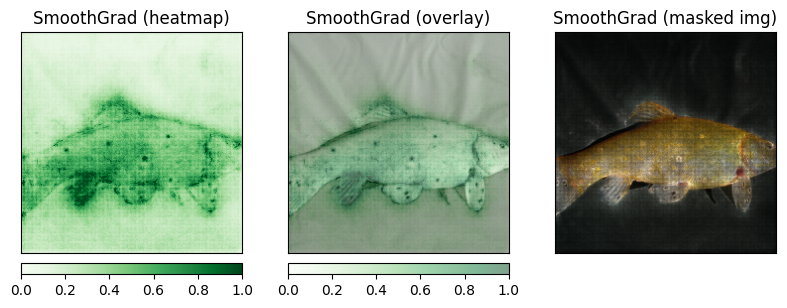

In [46]:
visualize_attributions(attr_sg, "SmoothGrad")

## Exercise 1

Compute the explanations of adversarial examples.
Use the PGD L-inf attack, with eps=0.3.

In [47]:
import foolbox as fb


preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = fb.PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)
attack = fb.attacks.LinfPGD()
epsilon = 0.1
raw_advs, _, success = attack(fmodel, unnorm_x.unsqueeze(0).to(device),
                              torch.tensor([y_true]).to(device), epsilons=epsilon)

y_pred: axolotl


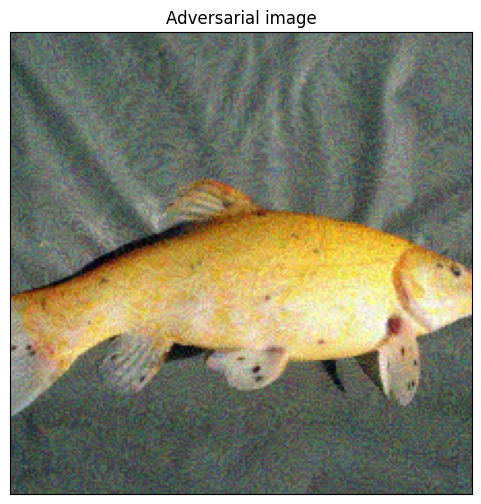

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Adversarial image'}>)

In [48]:
y_adv = model(raw_advs).squeeze(0).softmax(0).argmax().item()
print("y_pred:", weights.meta["categories"][y_adv])

viz.visualize_image_attr(None, tensor_to_img_array(raw_advs.squeeze(0)), method="original_image", title="Adversarial image")

## Explaining language models

In the second part of this tutorial we switch to the Natural Language Processing domain, focusing on transformer-based architectures. In particular we consider [BERT](https://arxiv.org/abs/1810.04805), a Large Language Model (LLM) pre-trained on a large text corpus which can be quickly fine-tuned on a wide range of downstream tasks, by attaching a different layer on top of the representation space.

We will rely to the [Hugging Face](https://huggingface.co) `transformers` library, which provides APIs, tools, and an open model zoo to easily download and load available models.

For this tutorial we select a text classification model that tries to infer emotions, among six different classes (sadness, joy, love, anger, fear, surprise). We start loading the [pre-trained model](https://huggingface.co/nateraw/bert-base-uncased-emotion) from Hugging Face.

In [49]:
import transformers


# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "nateraw/bert-base-uncased-emotion", use_fast=True
)
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "nateraw/bert-base-uncased-emotion"
).to(device)

# build a pipeline object to do predictions
transf_pipeline = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device,
    return_all_scores=True,  # observe the model’s behavior for all classes, not just the top output
)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [50]:
# write a sentence
data = ["I am not happy, I'm sad rather than happy"]

# we first classify it
print(transf_pipeline(data)[0])

[{'label': 'sadness', 'score': 0.10323862731456757}, {'label': 'joy', 'score': 0.8760595917701721}, {'label': 'love', 'score': 0.013690226711332798}, {'label': 'anger', 'score': 0.0043201507069170475}, {'label': 'fear', 'score': 0.0016321230214089155}, {'label': 'surprise', 'score': 0.001059297937899828}]


### SHAP

To provide local explanations we use [SHAP](https://github.com/shap/shap) (SHapley Additive exPlanations), a black-box unified framework based on Shapley values, a method from cooperative game theory that assigns each feature an importance value for a particular prediction.

> [[lundberg2017shap]](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) Scott M. Lundberg and Su-In Lee. 2017. A unified approach to interpreting model predictions. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17). Curran Associates Inc., Red Hook, NY, USA, 4768-4777.

Among the available techniques implemented in SHAP, we leverage the `Partition` method, which computes Shapley values recursively through a hierarchy of features by masking (i.e., removing) features from the input sample during
the computation of the explanation and evaluating the model outputs, capturing the correlation between input features.

SHAP fully support Hugging Face transformers library, so that we only have to pass the classifier pipeline to the explainer.

In [51]:
import shap


masker = shap.maskers.Text(transf_pipeline.tokenizer)

print(masker.shape("I like this movie."))

print(masker(np.array([True] * 7), "I like this movie."))

print(masker(np.array([True, True, False, False, True, True, True]), "I like this movie."))

(1, 7)
(array(['I like this movie.'], dtype='<U18'),)
(array(['I [MASK] [MASK]movie.'], dtype='<U21'),)


In [52]:
# wrap the classifier
transf_pipeline = shap.models.TransformersPipeline(transf_pipeline, rescale_to_logits=True)

# initialize the explainer
explainer = shap.Explainer(transf_pipeline)

# compute the attributions
shap_values = explainer(data)

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.40s/it]               


### Visualize force plots

Once the SHAP values are computed, we can visualize feature attributions towards individual classes through force plots.

The base value is what the model outputs when the entire input text is masked, while $f_{class}(inputs)$ is the output of the model for the full original input. The SHAP values explain in an additive way how the impact of unmasking each word changes the model output from the base value (where the entire input is masked) to the final prediction value.

In [53]:
shap.plots.text(shap_values)


### Global explanations

If we compute the local explanations on a set of samples and aggregate the results, we can obtain the most relevant features that influence the behavior of the model on that dataset.

We first load an emotion dataset from Hugging Face and randomly pick 10 samples, then compute SHAP values on them.

In [54]:
import datasets
import pandas as pd


# load the emotion dataset
dataset = datasets.load_dataset("emotion", split="train")
data = pd.DataFrame({"text": dataset["text"], "emotion": dataset["label"]})

# get attributions for ten random samples
shap_values = explainer(data.sample(10, random_state=123)["text"])

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 3/10 [00:59<02:50, 24.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 4/10 [02:35<05:25, 54.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 5/10 [04:03<05:33, 66.75s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 6/10 [04:58<04:10, 62.64s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 7/10 [05:18<02:25, 48.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [07:18<02:22, 71.38s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 9/10 [07:33<00:53, 53.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 10/10 [09:22<00:00, 70.87s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [10:08, 60.86s/it]


### Visualize results

We can plot the most relevant features that impact a single class through a bar chart, after averaging the attributions for the selected class.

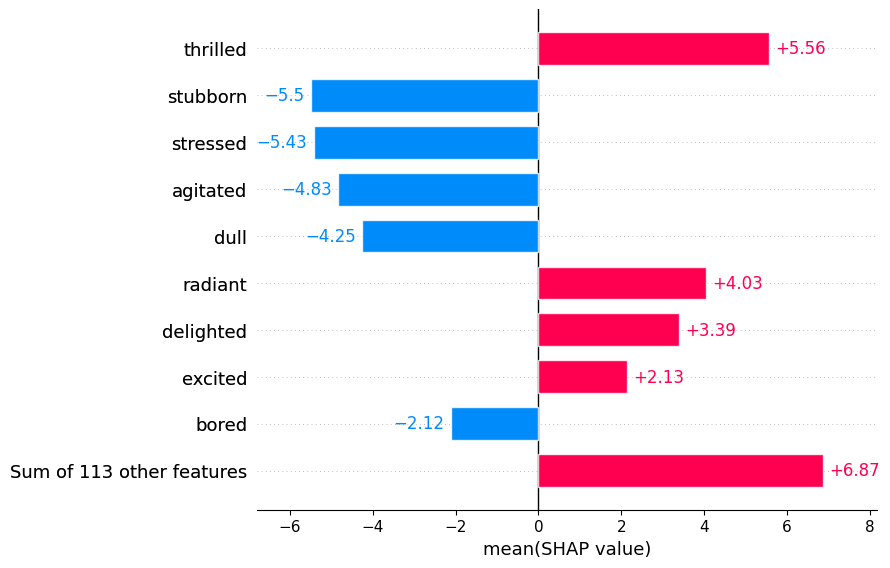

In [55]:
red_shap_values = shap_values[:, :, "joy"].mean(0)

shap.plots.bar(red_shap_values)

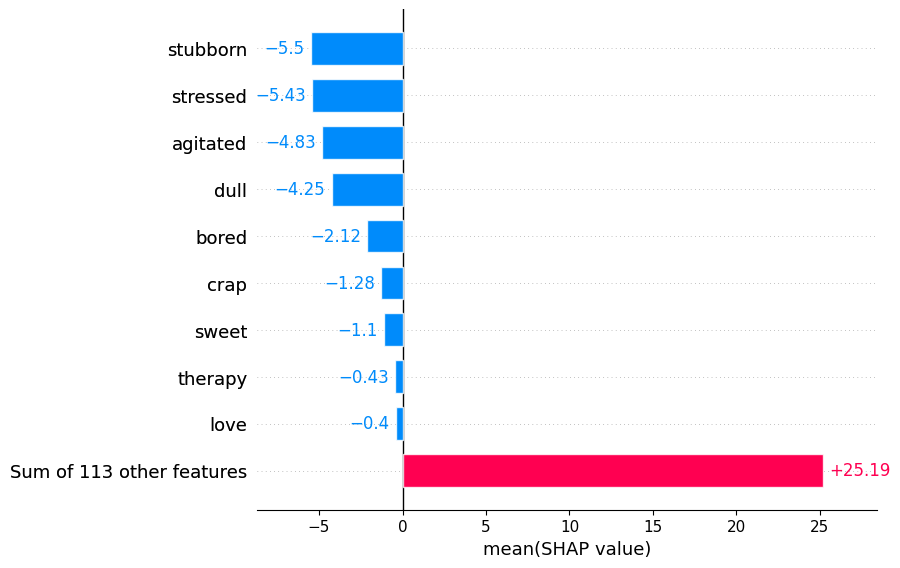

In [56]:
# we can sort the bar chart in decending order
shap.plots.bar(red_shap_values, order=shap.Explanation.argsort)

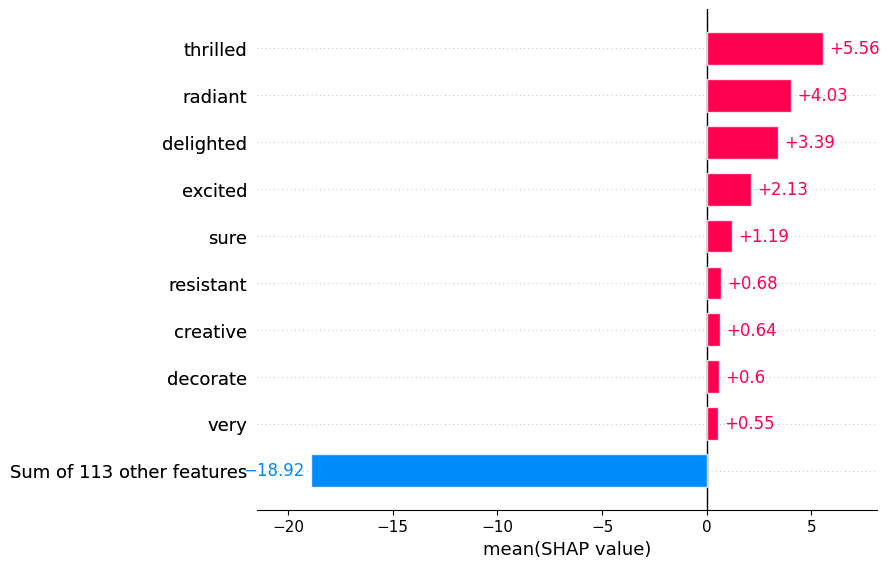

In [57]:
# ...or acending order
shap.plots.bar(red_shap_values, order=shap.Explanation.argsort.flip)